In [80]:
import pandas as pd
import umap.umap_ as umap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [81]:
data_train = pd.read_csv('data/train.csv').drop('id', axis=1)
data_test = pd.read_csv('data/test.csv').drop('id', axis=1)

In [82]:
all_data = pd.concat([data_train, data_test], axis=0)

In [83]:
data_train

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0              0          0          1          0          1          0   
1              0          0          0          0          2          1   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
99995          0          0          0          1          0          0   
99996          0          0          0          0          0          0   
99997          0          0          0          0          0          1   
99998          0          0          0          0          1          0   
99999          0          0          0          0          0          0   

       feature_6  feature_7  feature_8  feature_9  ...  feature_41  \
0              0          0          0          0  ...           0   
1              0          0          0          0  ...           0   
2              0          0          0          2  ...           0   
3              0          3          0          0  ...           0   
4              0          0          0          0  ...           0   
...          ...        ...        ...        ...  ...         ...   
99995          0          2          0          0  ...           0   
99996          0          1          2          0  ...           0   
99997          0          0          0          4  ...           0   
99998          0          0          0          5  ...           0   
99999          0          0          0          3  ...           0   

       feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0               0          21           0           0           0           0   
1               0           0           0           0           0           0   
2               1           0           0           0           0          13   
3               0           0           0           0           0           0   
4               0           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
99995           0           6           0           0           3           0   
99996           2           0           0           0          10           0   
99997           0           0           0           1           0           0   
99998           0           0           0           0           1           0   
99999           5           0           0           0           1           0   

       feature_48  feature_49   target  
0               0           0  Class_2  
1               0           0  Class_1  
2               2           0  Class_1  
3               1           0  Class_4  
4               1           0  Class_2  
...           ...         ...      ...  
99995           0           0  Class_1  
99996           0           0  Class_2  
99997           2           0  Class_3  
99998           4           0  Class_2  
99999           0           8  Class_3  

[100000 rows x 51 columns]

<h2>EDA</h2>

<h3>Missing values</h3>

In [84]:
all_data.isnull().sum()

feature_0         0
feature_1         0
feature_2         0
feature_3         0
feature_4         0
feature_5         0
feature_6         0
feature_7         0
feature_8         0
feature_9         0
feature_10        0
feature_11        0
feature_12        0
feature_13        0
feature_14        0
feature_15        0
feature_16        0
feature_17        0
feature_18        0
feature_19        0
feature_20        0
feature_21        0
feature_22        0
feature_23        0
feature_24        0
feature_25        0
feature_26        0
feature_27        0
feature_28        0
feature_29        0
feature_30        0
feature_31        0
feature_32        0
feature_33        0
feature_34        0
feature_35        0
feature_36        0
feature_37        0
feature_38        0
feature_39        0
feature_40        0
feature_41        0
feature_42        0
feature_43        0
feature_44        0
feature_45        0
feature_46        0
feature_47        0
feature_48        0
feature_49        0


As we can see there aren't any missing values in this dataset

<h3>Feature Description</h3>

In [85]:
data_test.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

In [86]:
data_train.describe().T.style.bar(subset=['mean', 'std'], color='#d65f5f')

<h3>Target Distribution</h3>

In [87]:
fig = go.Figure()

to_plot = data_train.value_counts('target')

fig.add_trace(go.Pie(
    labels = to_plot.index,
    values = to_plot.values,
    textinfo='label+percent'
))

fig.update_layout(
    template='plotly_dark',
    title_text = 'Target Distribution'
)

Unfortunately we have huge disbalance in our target variable. We will do something with this if it's gona be a problem later

<h3>Features Distribution</h3>

In [88]:
fig = make_subplots(
    rows=10,
    cols=5,
    subplot_titles=data_train.columns,
)

# Add traces
columns = data_train.drop('target', axis=1).columns.tolist()

for row in range(10):
    for col in range(5):
        column = columns.pop(0)
        to_plot = data_train[column].value_counts()

        fig.add_trace(go.Scatter(
            x = to_plot.index,
            y = to_plot.values,
            name = column,
            mode='lines'
        ), col=col+1, row=row+1)

        fig.update_yaxes(title='y', visible=False, showticklabels=False)

        if(col+1 == 5):
            break

fig.update_layout(
    height=1000,
    width=700,
    showlegend=False,
    template='plotly_dark',
)
fig.update_annotations(font_size=12)

There is a lot of zero values in every feature. I'm curious how much of dataset is filled with them.

In [89]:
to_plot = data_train.drop('target', axis=1).isin([0]).sum(axis=0)
percent = np.array(to_plot)/100000 * 100

fig = go.Figure()

fig.add_trace(go.Bar(
    x = to_plot.values,
    y = to_plot.index,
    orientation='h',
    text = np.round(percent, 2),
    textposition='outside',
    marker={
        'color': to_plot.values,
        'colorscale': 'Purples',

    }
))

fig.update_layout(
    height=1000,
    width=700,
    template='plotly_dark',
    title_text='Percent of zeros in every column'
)

<h3>Correlation</h3>

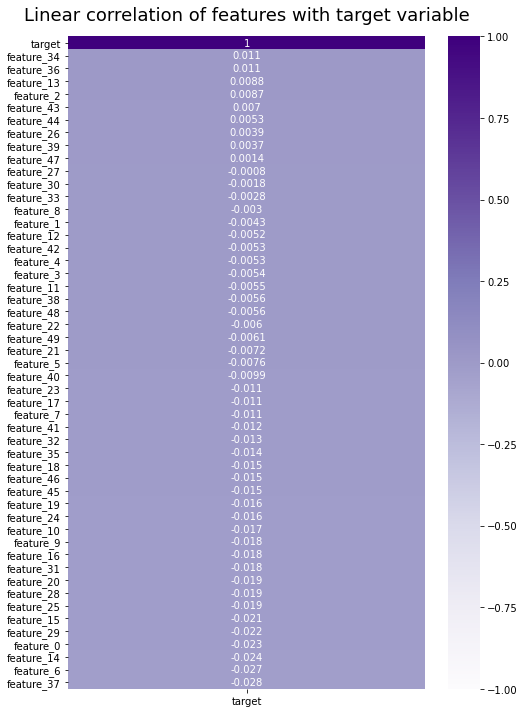

In [90]:
data_train_target_num = data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})

plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(data_train_target_num.corr()[['target']].sort_values(by='target', ascending=False),
                     vmin=-1, vmax=1, annot=True, cmap='Purples')

heatmap.set_title('Linear correlation of features with target variable', fontdict={'fontsize': 18}, pad=16);

<h3>Conclusion</h3>

After some visualization and discussion couple of things come up to the light
<ul>
    <li>There aren't any missing values</li>
    <li>Mean and standard deviation is fairly the same for train and test datasets</li>
    <li>Target variable is unbalanced which can be a problem</li>
    <li>Features are left skewed and nearly 60% of every feature is filled with zeros</li>
    <li>Features show weak linear correlation with target variable</li>
</ul>

<h2>Dimensionality Reduction</h2>
There is 50 features in our dataset. It's good opportunity to perform dimensionality reduction but first we gona check if it's necessary to do so.

In [91]:
pca = PCA().fit(data_train.drop('target', axis=1))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = list(range(50)),
    y = np.cumsum(pca.explained_variance_ratio_)
))

fig.update_layout(
    template = 'plotly_dark',
    title_text = 'PCA Performence',
    xaxis_title = 'Number of components',
    yaxis_title = 'Cumulative explained variance'
)

As we can see from scatter plot above variance decreasing quite fast. By the time PCA reduce number of features to the 30 we had lost almost 10% of the variance. It's definitely not worth it to reduce dimensionality of this dataset in order to create prediction model but still we can use dimensionality reduction to visualize our dataset. 

In [92]:
pca_vis = PCA(3)
projected = pca_vis.fit_transform(data_train.drop('target', axis=1))

In [93]:
df_vis = pd.DataFrame(projected, columns=['x', 'y', 'z'])
df_vis['target'] = data_train['target']

In [94]:
fig = px.scatter_3d(df_vis, x='x', y='y', z='z', color='target')

# tight layout
fig.update_layout(
    template='plotly_dark'
)

In [108]:
sample_data_train = data_train.sample(1000, random_state=42)
scaled_sample_train = pd.DataFrame(StandardScaler().fit_transform(sample_data_train.drop('target', axis=1)))
scaled_sample_target = sample_data_train.replace({'target': {'Class_1': 1, 'Class_2': 2, 'Class_3': 3, 'Class_4': 4}})['target'].reset_index(drop=True)

In [66]:
reducer = umap.UMAP(min_dist=0.1)
embedding = reducer.fit_transform(scaled_sample_train, scaled_sample_target)

ValueError: could not convert string to float: 'Class_4'

In [58]:
df_test = pd.DataFrame(embedding, columns=['x', 'y'])
df_test['target'] = data_train['target']

In [59]:
df_test

x         y   target
0     7.047492 -1.060713  Class_2
1     4.891326  1.581900  Class_1
2     6.529067 -1.630886  Class_1
3     7.339480 -1.444456  Class_4
4     6.856402 -1.632882  Class_2
..         ...       ...      ...
995   9.054070 -0.024873  Class_2
996  10.201949 -0.726487  Class_4
997   9.423254 -0.581216  Class_2
998  10.065490  0.735714  Class_2
999   8.676089  0.054365  Class_1

[1000 rows x 3 columns]

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = df_test[df_test['target'] == 'Class_1']['x'],
    y = df_test[df_test['target'] == 'Class_1']['y'],
    mode='markers',
    name='Class_1'
))

fig.add_trace(go.Scatter(
    x = df_test[df_test['target'] == 'Class_2']['x'],
    y = df_test[df_test['target'] == 'Class_2']['y'],
    mode='markers',
    name='Class_2'
))

fig.add_trace(go.Scatter(
    x = df_test[df_test['target'] == 'Class_3']['x'],
    y = df_test[df_test['target'] == 'Class_3']['y'],
    mode='markers',
    name='Class_3'
))

fig.add_trace(go.Scatter(
    x = df_test[df_test['target'] == 'Class_4']['x'],
    y = df_test[df_test['target'] == 'Class_4']['y'],
    mode='markers',
    name='Class_4'
))